In [127]:
# importing labraries
import numpy as np
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.optimize import brentq, curve_fit, least_squares
from scipy.stats import norm
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

> # PART II

In [128]:
# import excel data
discount = pd.read_csv('zero_rates_20201201.csv')
spx_df = pd.read_csv('SPX_options.csv')
spy_df = pd.read_csv('SPY_options.csv')
S0_spx = 3662.45
S0_spy = 366.02

## Market Volatility
We proceed to define a function using brentq solver to retrieve the implied vol from our given data. Also included are the Black-Scholes lognormal (S), Bachelier Normal (S) & Displaced Diffusion functions (F).

Recall that <b> Implied Volatility</b> is defined as <b>the value of $\sigma$ such that the Black Scholes Call option formula produces the same price as the observable option price.</b>  

In [129]:
# define Black Scholes Lognormal pricing functions
def Black_Scholes(S, K, r, sigma, T, opt):
    d1 = (math.log(S / K) + (r + (sigma ** 2) / 2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    if opt == 'C':
        return (S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2))
    if opt == 'P':
        return (-S * norm.cdf(-d1) + K * math.exp(-r * T) * norm.cdf(-d2))

# # Bachelier Normal pricing functions
# def Bachelier(S, K, r, sigma, T, opt):
#     d = (K - S) / (sigma * np.sqrt(T)) # why must times S to make things right? 
#     if opt == 'C':
#         return math.exp(-r * T) *\
#         ((S - K) * norm.cdf(-d) + sigma * math.sqrt(T) * norm.pdf(-d))
#     if opt == 'P':
#         return math.exp(-r * T) *\
#         ((K - S) * norm.cdf(d) + sigma * math.sqrt(T) * norm.pdf(d))

    # Displaced Diffusion also called Shifted Lognormal using F instead of S
def Displaced_Diffusion(F, K, beta, r, sigma, T, opt):
    Fd = F/beta
    Kd = K + ((1-beta)/beta)*F
    sigma_d = sigma*beta
    return Black_Scholes(Fd, Kd, r, sigma_d, T, opt)

def impliedVolatility(S, K, r, price, T, opt, func):
    try:
        impliedVol = brentq(lambda x: price -
                            func(S, K, r, x, T, opt),
                            1e-6, 12000)
    except Exception:
        impliedVol = np.nan

    return impliedVol

Here we try to estimate on discount factors for future use.

Note that the interest rates provided in the 'rate' column are in % unit. So for instance, to discount a cashflow paid 49 days from today, the discount factor is

\begin{equation*}
\begin{split}
D(0,T) = e^{-0.00216480 \times \frac{49}{365}}
\end{split}
\end{equation*}


If the payment date is not provided in the dataframe, you can perform linear interpolation for the corresponding zero rate.

In [130]:
def get_smile_df(df, discount_df, S0, func):
    
    df_cal = df.copy()
    df_cal['T'] =\
            df_cal['exdate']\
            .apply(lambda x: \
                   (pd.Timestamp(str(x))
                   .date() - dt.date(2020, 12, 1))
                   .days)

    df_cal['r'] =\
            df_cal['T']\
            .apply(lambda x: \
                   np.interp(x, discount_df['days'], discount_df['rate'])/100)

    df_cal['F'] =\
            S0 * np.exp(df_cal['r'] * df_cal['T']/365)
    
    # filter out in-the money options and organise dataframes
    # call 
    call = df_cal[df_cal['cp_flag']=='C']
    call['mid_price'] = (call['best_bid'] + call['best_offer']) / 2    
    call = call[call['strike_price']/1000 >= S0]
    
    # put    
    put = df_cal[df_cal['cp_flag']=='P']
    put['mid_price'] = (put['best_bid'] + put['best_offer']) / 2
    put = put[put['strike_price']/1000 <= S0]   
    
    df_smile = pd.concat([put, call])  
    
    df_smile['vol_m'] =\
        df_smile.apply(lambda x:\
                     impliedVolatility(S0,
                                       x['strike_price']/1000,
                                       x['r'],
                                       x['mid_price'],
                                       x['T']/365,
                                       x['cp_flag'],
                                       func),
                          axis=1)
    # df_smile will contain na values, so will smiles
    smiles = []
    for F0 in df_smile['F'].unique():
        smiles += [df_smile[df_smile['F'] == F0]]      
    
    return smiles

In [131]:
spx_smile = get_smile_df(spx_df, discount, S0_spx, Black_Scholes)
spy_smile = get_smile_df(spy_df, discount, S0_spy, Black_Scholes)

In [132]:
def plot_smiles(list_of_smile, name_tag):    
    # Create a figure for the plot
    plt.figure(figsize=(10, 6))

    # Iterate through the list of DataFrames and columns
    for i, df in enumerate(list_of_smile):
        y_values = df['vol_m']     # Retrieve the data from the current DataFrame
        # Plot the data against the shared x-axis
#         plt.plot(df['strike_price'] / 1000, y_values)
        plt.scatter(df['strike_price'] / 1000, y_values, marker='s',\
                    label=f"Maturity = {df['T'].iloc[0]} Days")


    # Add labels and a legend
    plt.xlabel('Strike_price')
    plt.ylabel('Implied Volitality')
    plt.title(f'{name_tag} Volitality Smile')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()        
    return

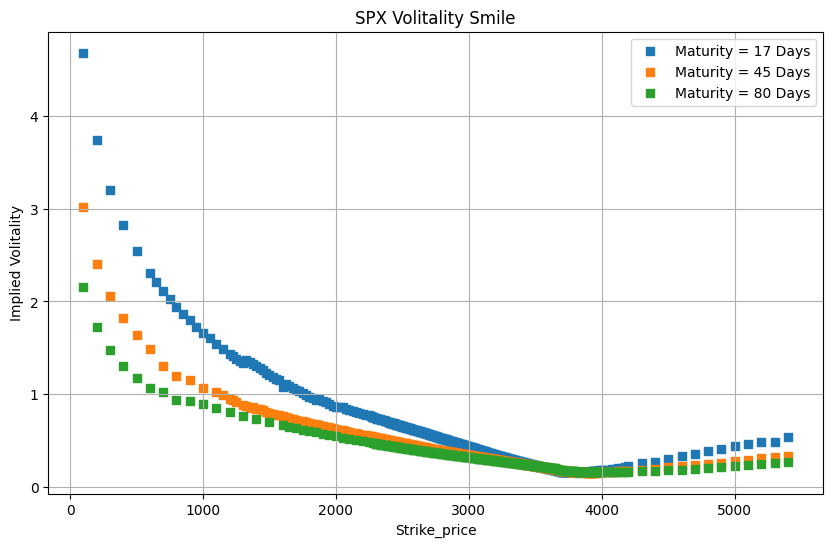

In [133]:
plot_smiles(spx_smile, 'SPX')

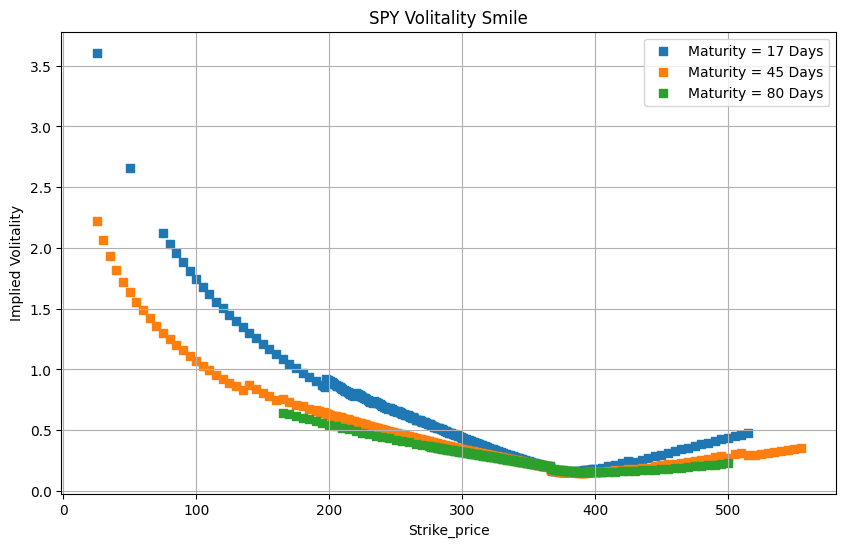

In [134]:
plot_smiles(spy_smile, 'SPY')

## ATM Volatility
Here we implement the solver to find the at-the-money implied volatility

In [135]:
def ATM_Vol(df, S0):
    ATM_slice = df.copy()
    # Calculate the absolute differences between the target value and each row
    ATM_slice['Difference'] = abs(ATM_slice['strike_price']/1000 - S0)

    # Sort the DataFrame by the 'Difference' column
    ATM_slice = ATM_slice.sort_values(by='Difference').head(5)
#     print(ATM_slice)

    # Get the ONLY ONE closest row    
    K = ATM_slice.iloc[0]['strike_price']/1000
    r = ATM_slice.iloc[0]['r']
    price = ATM_slice.iloc[0]['mid_price']
    T = ATM_slice.iloc[0]['T']/365
    opt = ATM_slice.iloc[0]['cp_flag']
        
    sigma_LN = impliedVolatility(S0, K, r, price, T, opt, Black_Scholes)
    return sigma_LN

In [136]:
for i in range(len(spx_smile)):
    print(f"r for T = {spx_smile[i]['T'].iloc[0]} is {spx_smile[i]['r'].iloc[0]}")

r for T = 17 is 0.0012550044444444445
r for T = 45 is 0.0020510755555555554
r for T = 80 is 0.0022062799999999997


> ## `Diffusion model` Calibration

##  σ, β

σ is implied volitality calculated by Black-Scholes model

In [137]:
for i in range(len(spx_smile)):
    print(ATM_Vol(spx_smile[i], S0_spx))

0.17821496231603742
0.18886028486850842
0.19717431220334622


βis solved by least-square method using black-sholes implied volitality calculation on Displaced-Diffusion price.

In [138]:
def Diffusion_sigma(S0, K, beta, r, sigma, T, opt):
    D_price = Displaced_Diffusion(S0*np.exp(r*T), K, beta, r, sigma, T, opt)
    return impliedVolatility(S0, K, r, D_price, T, opt, Black_Scholes)

In [139]:
def Diffusioncalibration(df, S0, beta):
    D = df.copy()
    sigma_LN = ATM_Vol(D, S0)
    D['Sigma_D'] =\
        D.apply(lambda x:\
                     Diffusion_sigma(S0,
                                     x['strike_price']/1000,
                                     beta,
                                     x['r'],
                                     sigma_LN,
                                     x['T']/365,
                                     x['cp_flag']),
                 axis=1)
    D.dropna(inplace=True)
    err = ((D['vol_m'] - D['Sigma_D']) ** 2).sum()
    
    return err

In [140]:
def Diffusion_beta(df, S0):
       
    initialGuess = [0.7]
    bounds = (0, 1)
    res = least_squares(lambda x: Diffusioncalibration(df,
                                                       S0,
                                                       x),
                        initialGuess, bounds=bounds)
    beta = res.x[0]    
    
    return beta

In [141]:
def Diffusion_beta_list(df_list, S0, str_name):
    sigma_list = []
    beta_list = []
    T_list = []
    for df in df_list:
        T_list += [df['T'].iloc[0]]
        sigma_list += [ATM_Vol(df, S0)]
        beta_list += [Diffusion_beta(df, S0)]    
    result = pd.DataFrame({'Days to expiry': T_list,
                           f'{str_name}_σ': sigma_list,
                           f'{str_name}_β': beta_list})
    result = result.set_index('Days to expiry')
    return result

In [142]:
Diffusion_spx = Diffusion_beta_list(spx_smile, S0_spx, 'SPX')
Diffusion_spx

,SPX_σ,SPX_β
Days to expiry,,
17,0.178215,0.023665
45,0.188860,0.050115
80,0.197174,0.067859


In [143]:
Diffusion_spy = Diffusion_beta_list(spy_smile, S0_spy, 'SPY')
Diffusion_spy

,SPY_σ,SPY_β
Days to expiry,,
17,0.201551,0.024300
45,0.197767,0.044402
80,0.200653,0.121818


In [144]:
def Diffusion_plot_beta(df, S0, beta, name_tag):
    D = df.copy()
    sigma_LN = ATM_Vol(D, S0)
    D['Sigma_D'] =\
        D.apply(lambda x:\
                     Diffusion_sigma(S0,
                                     x['strike_price']/1000,
                                     beta,
                                     x['r'],
                                     sigma_LN,
                                     x['T']/365,
                                     x['cp_flag']),
                 axis=1)
    D.dropna(inplace=True)
    err = ((D['vol_m'] - D['Sigma_D']) ** 2).sum()    
    
    # Create a figure for the plot
    plt.figure(figsize=(10, 6))   
    
    plt.scatter(D['strike_price'] / 1000, D['vol_m'], marker='s', color = "blue",\
                    label=f"{name_tag} Market Vol") 
    
    plt.plot(D['strike_price'] / 1000, D['Sigma_D'], linestyle='-', color = "red",\
                    label="Diffusion model Vol") 
    plt.xlabel('Strike Price')  # Label for the x-axis
    plt.ylabel('Implied Volitality')  # Label for the y-axis
    plt.legend()
    plt.title(f"expiry of {D['T'].iloc[0]} Days modeled at β = {beta:.4f}")
    return

In [145]:
def Diffusion_plot_beta_list(df_list, S0, df_beta, name_tag):
    for i in range(len(df_beta)):
        beta = df_beta.iloc[i, 1]
        Diffusion_plot_beta(df_list[i], S0, beta, name_tag)
    return

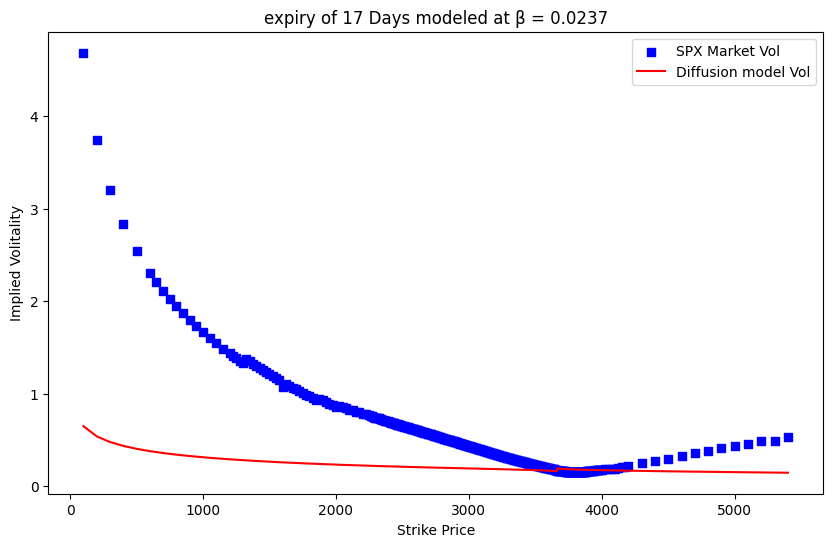

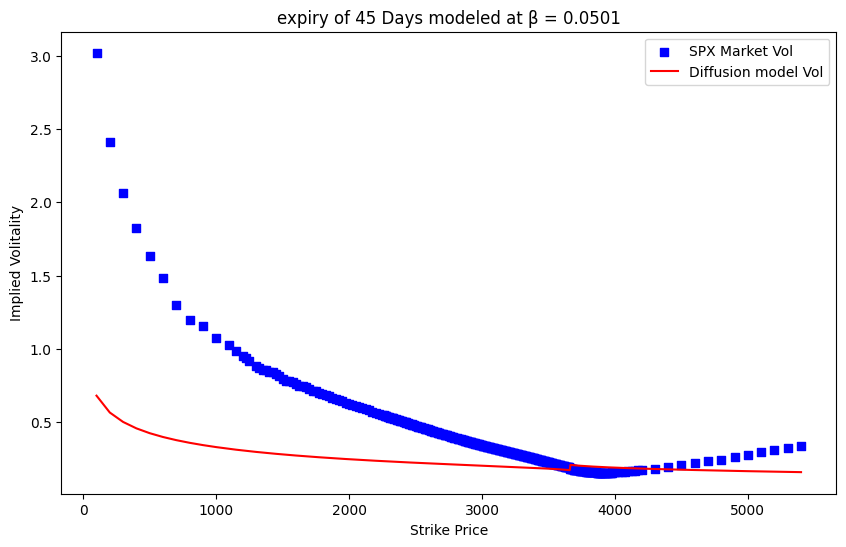

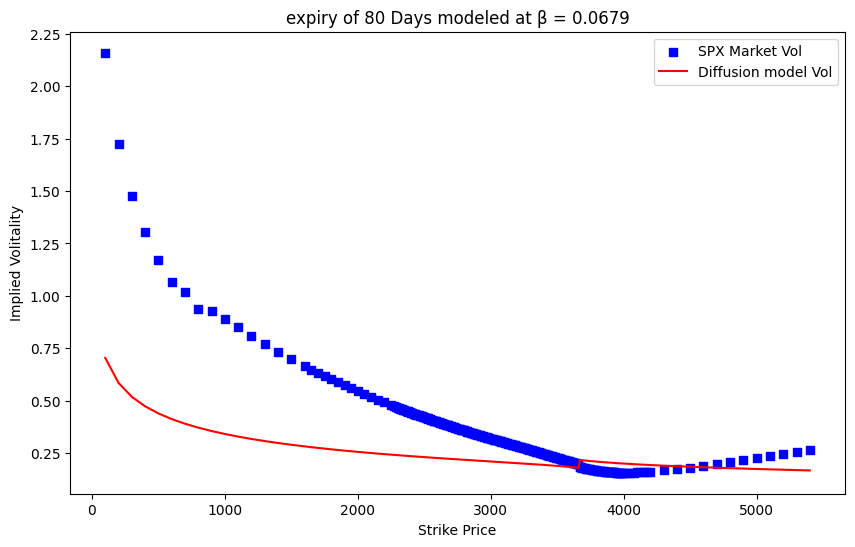

In [146]:
Diffusion_plot_beta_list(spx_smile, S0_spx, Diffusion_spx, "SPX")

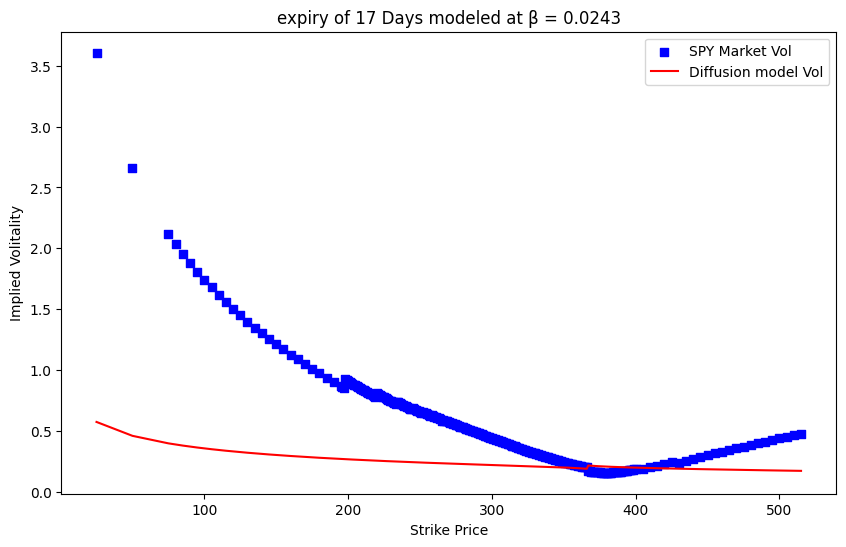

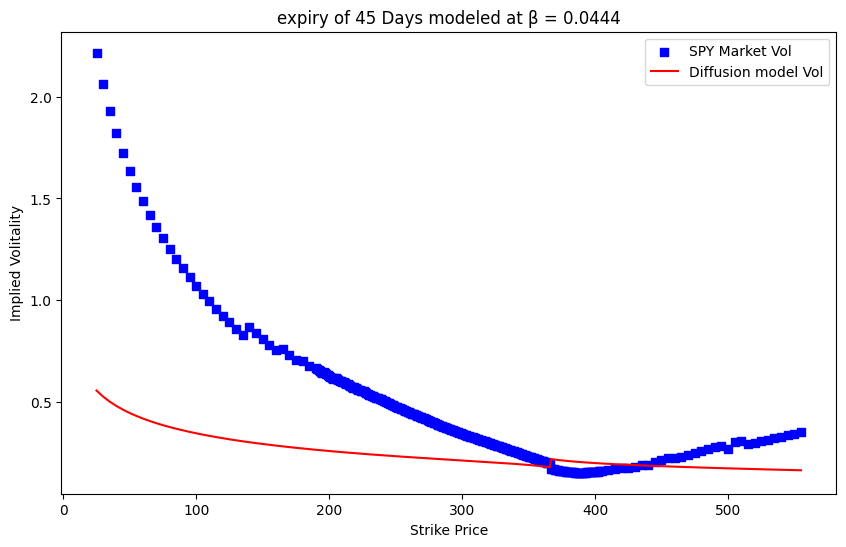

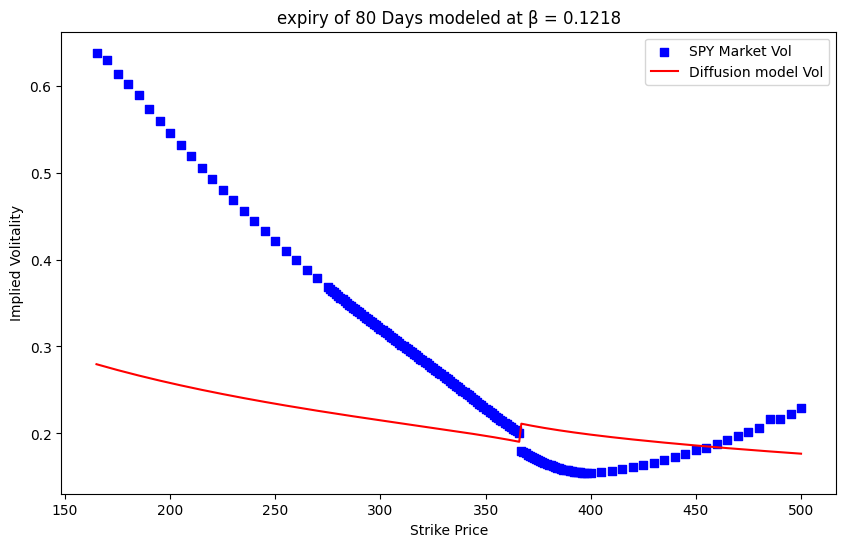

In [147]:
Diffusion_plot_beta_list(spy_smile, S0_spy, Diffusion_spy, "SPY")

> ## `Diffusion model` discussion
##  β example: SPX data on T = 17

In [148]:
def Diffusion_plot_beta_effect(df, S0, beta_test, name_tag):
    D = df.copy()
    sigma_LN = ATM_Vol(D, S0)
    
    for i in range(len(beta_test)):
        D[f'Sigma_D{i}'] =\
            D.apply(lambda x:\
                         Diffusion_sigma(S0,
                                         x['strike_price']/1000,
                                         beta_test[i],
                                         x['r'],
                                         sigma_LN,
                                         x['T']/365,
                                         x['cp_flag']),
                     axis=1)
    D.dropna(inplace=True)    
    # Create a figure for the plot
    plt.figure(figsize=(10, 6))      
#     plt.scatter(D['strike_price'] / 1000, D['vol_m'], marker='s', color = "blue",\
#                     label=f"{name_tag} Market Vol")     
    plt.axhline(y=sigma_LN, color='r', linestyle='--', label='σLN')    
    plt.text(0, sigma_LN, "σLN", va='top', ha='left')

    for i in range(len(beta_test)):        
        plt.plot(D['strike_price'] / 1000, D[f'Sigma_D{i}'], linestyle='-',\
                        label=f"β = {beta_test[i]}") 

    plt.xlabel('Strike Price')  # Label for the x-axis
    plt.ylabel('Implied Volitality')  # Label for the y-axis
    plt.legend()
    plt.title(f"expiry of {D['T'].iloc[0]} Days Diffusion model at various β")
    return

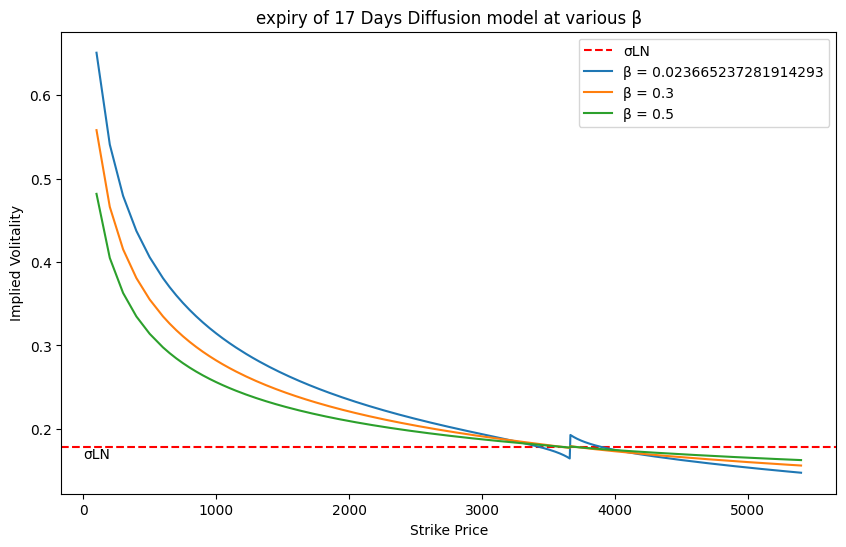

In [149]:
beta_list = [Diffusion_spx.iloc[0, 1], 0.3, 0.5]
Diffusion_plot_beta_effect(spx_smile[0], S0_spx, beta_list, "SPX")

# Conclusion: β range from (0, 1), controls the slope. Bigger β means more similarity to Log-Normal option pricing

> ## `SABR model` Calibration (fix β = 0.7)

##  α, ρ, ν

First, we shall implement the SABR model. The implied Black volatility of the SABR model is given by
  \begin{equation*}
    \begin{split}
      &\sigma_{\mbox{SABR}}(F_0, K, \alpha, \beta, \rho, \nu) \\
      &= \frac{\alpha}{(F_0K)^{(1-\beta)/2}\left\{ 1 + \frac{(1-\beta)^2}{24}\log^2\left(\frac{F_0}{K}\right) + \frac{(1-\beta)^4}{1920}\log^4\left(\frac{F_0}{K}\right) + \cdots\right\} } \\
      &\;\;\;\times \frac{z}{x(z)} \times \left\{ 1 + \left[
          \frac{(1-\beta)^2}{24}
          \frac{\alpha^2}{(F_0K)^{1-\beta}}+\frac{1}{4}\frac{\rho\beta\nu\alpha}{(F_0K)^{(1-\beta)/2}}+\frac{2-3\rho^2}{24}\nu^2\right]
        T + \cdots \right.
    \end{split}
  \end{equation*}
  where
  \begin{equation*}
    \begin{split}
      z = \frac{\nu}{\alpha} (F_0K)^{(1-\beta)/2}
      \log\left(\frac{F_0}{K}\right),
    \end{split}
  \end{equation*}
  and
  \begin{equation*}
    \begin{split}
      x(z) = \log \left[ \frac{\sqrt{1-2\rho z+z^2}+z -\rho}{1-\rho}
      \right].
    \end{split}
  \end{equation*}


This can be implemented in Python as follows:

In [150]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

To plot the implied volatility smile for the normal (Bachelier) model, just replaced the "BlackScholesCall" with the Bachelier formula.

Next, we look at the SABR model. The definition above contains the function

\begin{equation*}
\begin{split}
\mbox{SABR}(F, K, T, \alpha, \beta, \rho, \nu)
\end{split}
\end{equation*}

The function returns a volatility $\sigma_{\mbox{SABR}}$ for the Black76Lognormal call or put option formula, so that

\begin{equation*}
\begin{split}
\mbox{Call price} &= \mbox{BlackScholesCall}(S, K, r, \sigma_{\mbox{SABR}}, T) \\
\mbox{Put price} &= \mbox{BlackScholesPut}(S, K, r, \sigma_{\mbox{SABR}}, T) \\
\end{split}
\end{equation*}

How do we determine the parameters $\alpha$, $\rho$ and $\nu$?
- We choose them so that the output of the SABR model matches the implied volatilities observed in the market.
- We refer to this process as "model calibration".

In other words, defining

  \begin{equation*}
    \begin{split}
      \sigma_{\mbox{Mkt}}(K_1) - \mbox{SABR}(F, K_1, T, \alpha, 0.7, \rho, \nu) &= \epsilon_1 \\
      \sigma_{\mbox{Mkt}}(K_2) - \mbox{SABR}(F, K_2, T, \alpha, 0.7, \rho, \nu) &= \epsilon_2 \\
      \vdots&\\
      \sigma_{\mbox{Mkt}}(K_n) - \mbox{SABR}(F, K_n, T, \alpha, 0.7, \rho, \nu) &= \epsilon_n \\
    \end{split}
  \end{equation*}

We want to minimize the sum of squared error terms as follows:
  
  \begin{equation*}
    \begin{split}
      \min_{\substack{\alpha,\; \rho,\; \nu}} \;\sum_{i=1}^n \epsilon_i^2
    \end{split}
  \end{equation*}

We use the "least_squares" algorithm in "scipy" package to calibrate the SABR model parameters:

In [151]:
beta_fix = 0.7
def sabrcalibration(df, guess, beta):
    F = df['F'].iloc[0]
    T = df['T'].iloc[0] / 365
    sabr = df.copy()
    
    sabr['Sigma_SABR'] = \
        sabr.apply(lambda x:\
                       SABR(F, x['strike_price']/1000, T,
                           guess[0], beta, guess[1], guess[2]),
                   axis = 1)
#     sabr.dropna(inplace=True)
    err = ((sabr['vol_m'] - sabr['Sigma_SABR']) ** 2).sum()
    return err

In [152]:
def sabr_fit(df, beta):
    F = df['F'].iloc[0]
    T = df['T'].iloc[0] / 365
    

    initialGuess = [0.02, 0.2, 0.1]
    bounds = ([0, -1, 0], [float('inf'), 1, float('inf')])
    res = least_squares(lambda x: sabrcalibration(df, x, beta),
                        initialGuess, bounds=bounds)
    alpha = res.x[0]
    rho = res.x[1]
    nu = res.x[2]    
    
    
    return [alpha, beta, rho, nu]

In [153]:
sabr_test = sabr_fit(spx_smile[0], beta_fix)
sabr_test

[1.2122949037115889, 0.7, -0.3008975176333741, 5.459778120578204]

In [154]:
def sabr_fit_list(df_list, beta, name_tag):
    result = []
    index_T = []
    column_names = [f'{name_tag}_𝛼', f'{name_tag}_𝛽',
                    f'{name_tag}_𝜌', f'{name_tag}_𝜈']
    for df in df_list:
        index_T += [df['T'].iloc[0]]
        result += [sabr_fit(df, beta_fix)]
    result = pd.DataFrame(result, index=index_T, columns=column_names)
    result.index = pd.Index(result.index, name="Days to expiry")
    return result

In [155]:
sabr_spx = sabr_fit_list(spx_smile, beta_fix, 'SPX')
sabr_spx

,SPX_𝛼,SPX_𝛽,SPX_𝜌,SPX_𝜈
Days to expiry,,,,
17,1.212295,0.7,-0.300898,5.459778
45,1.805269,0.7,-0.390537,2.800936
80,2.140142,0.7,-0.574916,1.841737


In [156]:
sabr_spy = sabr_fit_list(spy_smile, beta_fix, 'SPY')
sabr_spy

,SPY_𝛼,SPY_𝛽,SPY_𝜌,SPY_𝜈
Days to expiry,,,,
17,0.664672,0.7,-0.411839,5.251738
45,0.908142,0.7,-0.488776,2.728522
80,1.120922,0.7,-0.632938,1.742224


In [157]:
def SABR_plot_fit(df, alpha, beta, rho, nu, name_tag):
    
    F = df['F'].iloc[0]
    T = df['T'].iloc[0] / 365
    sabr = df.copy()
      
    sabr['Sigma_SABR'] = \
        sabr.apply(lambda x:\
                       SABR(F, x['strike_price']/1000, T,
                           alpha, beta, rho, nu),
                   axis = 1)
#     sabr.dropna(inplace=True)
    err = ((sabr['vol_m'] - sabr['Sigma_SABR']) ** 2).sum()
    
    # Create a figure for the plot
    plt.figure(figsize=(10, 6))   
    
    plt.scatter(sabr['strike_price'] / 1000, sabr['vol_m'], marker='s',\
                color = "blue", label=f"{name_tag} Market Vol") 
    
    plt.plot(sabr['strike_price'] / 1000, sabr['Sigma_SABR'], linestyle='-',\
                 color = "red", label="SABR model Vol") 
    plt.xlabel('Strike Price')  # Label for the x-axis
    plt.ylabel('Implied Volitality')  # Label for the y-axis
    plt.legend()
    plt.title(f"expiry of {sabr['T'].iloc[0]} Days modeled at \
    α = {alpha:.4f} β = {beta:.4f} ρ = {rho:.4f} ν = {nu:.4f}")
    return

In [158]:
def SABR_plot_fit_list(df_list, df_sabr_fit, name_tag):
    for i in range(len(df_list)):
        alpha = df_sabr_fit.iloc[i, 0]
        beta = df_sabr_fit.iloc[i, 1]
        rho = df_sabr_fit.iloc[i, 2]
        nu = df_sabr_fit.iloc[i, 3]
        
        SABR_plot_fit(df_list[i], alpha, beta, rho, nu, name_tag)
    return

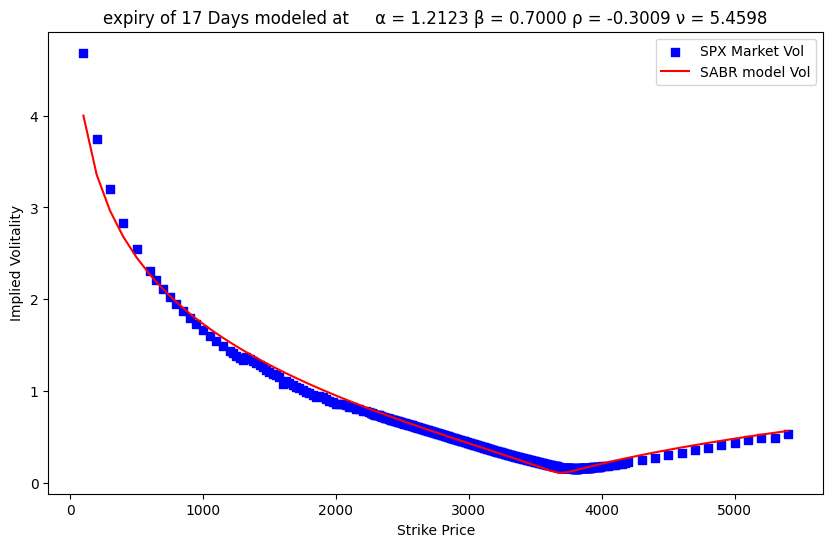

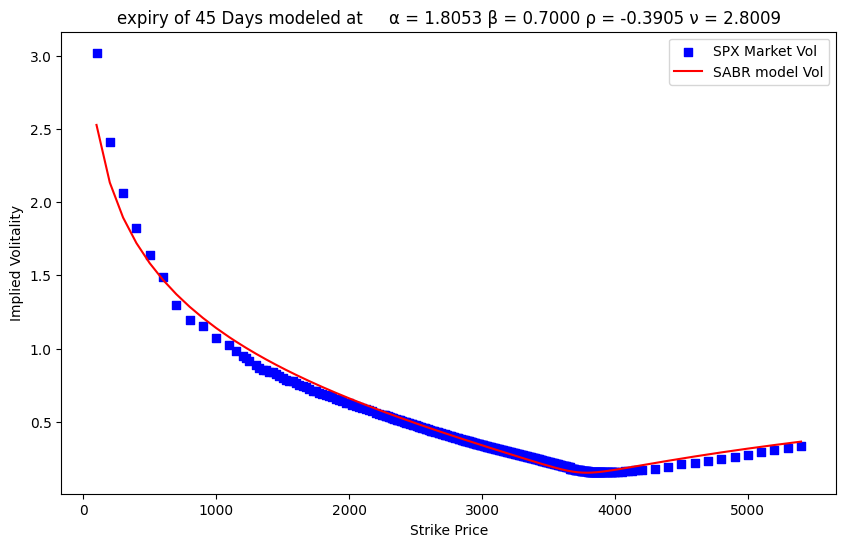

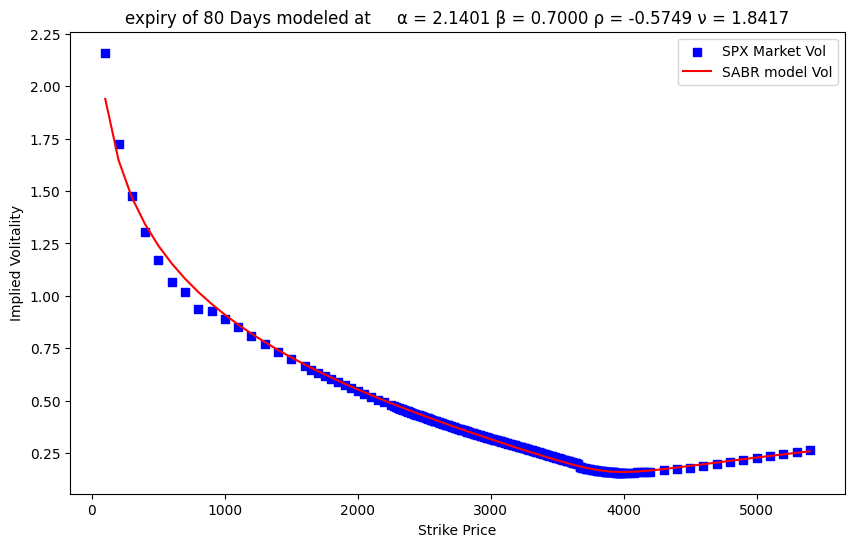

In [159]:
SABR_plot_fit_list(spx_smile, sabr_spx, "SPX")

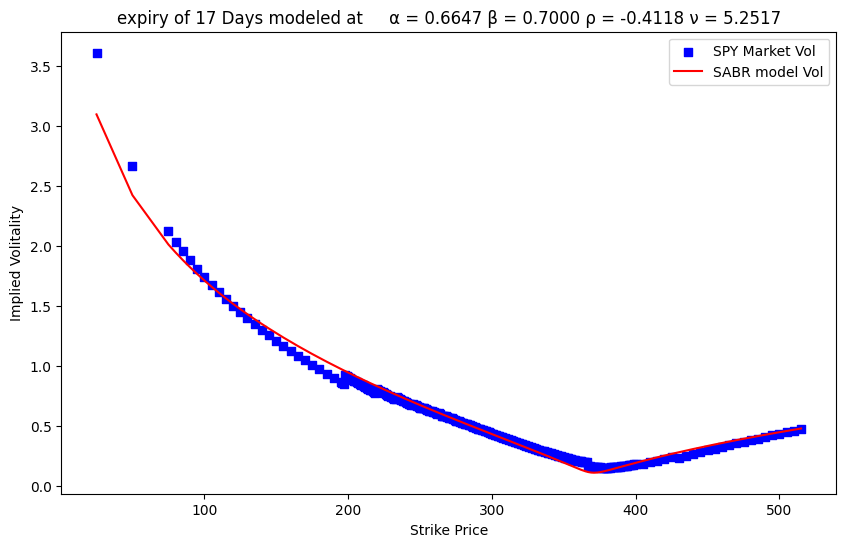

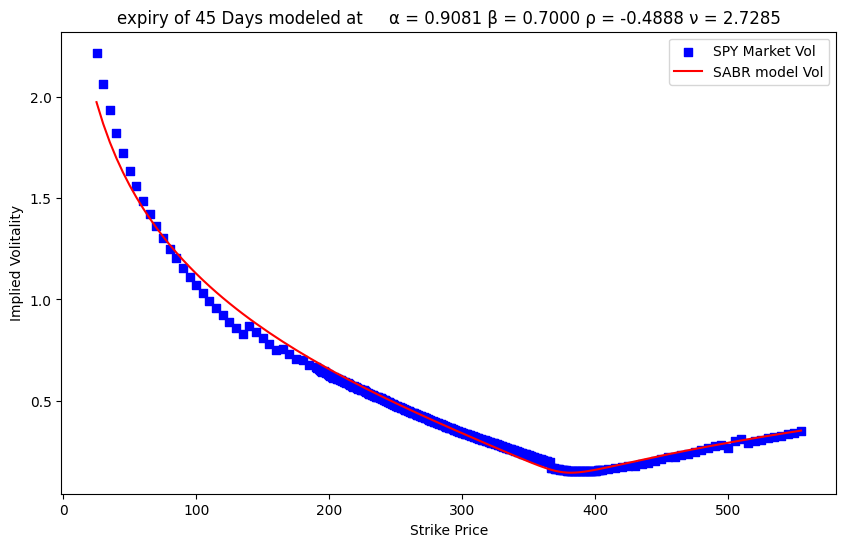

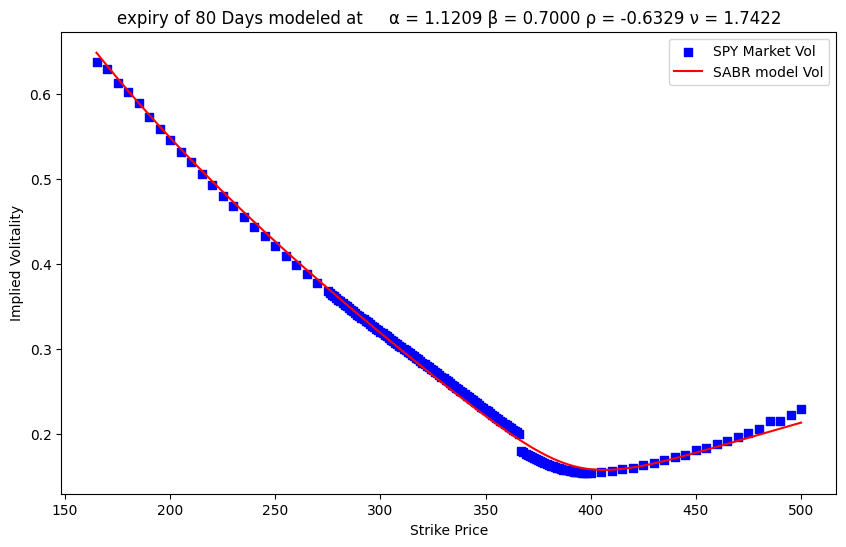

In [160]:
SABR_plot_fit_list(spy_smile, sabr_spy, "SPY")

> ## `SABR model` discussion
##  ρ example: SPX data on T = 17

In [161]:
def SABR_plot_effect(df, alpha, beta, rho_list, nu_list, name_tag):
    
    F = df['F'].iloc[0]
    T = df['T'].iloc[0] / 365
    sabr = df.copy()
#     Create a figure for the plot
    plt.figure(figsize=(10, 6))      
    plt.scatter(sabr['strike_price'] / 1000, sabr['vol_m'], marker='s', s=10, \
                color = "r", label=f"{name_tag} Market Vol") 
    
    if len(rho_list) > 1:
        for i in range(len(rho_list)):
            sabr[f'Sigma_ρ{i}'] = \
            sabr.apply(lambda x:\
                           SABR(F, x['strike_price']/1000, T,
                               alpha, beta, rho_list[i], nu_list[0]),
                       axis = 1)
            sabr.dropna(inplace=True)
            plt.plot(sabr['strike_price'] / 1000, sabr[f'Sigma_ρ{i}'],\
                         linestyle='-', label= f"ρ = {rho_list[i]}") 
        plt.title(f"expiry of {sabr['T'].iloc[0]} Days SABR model at various ρ")                        

    elif len(nu_list) > 1:
        for i in range(len(nu_list)):
            sabr[f'Sigma_ν{i}'] = \
            sabr.apply(lambda x:\
                           SABR(F, x['strike_price']/1000, T,
                               alpha, beta, rho_list[0], nu_list[i]),
                       axis = 1)
            sabr.dropna(inplace=True)
            plt.plot(sabr['strike_price'] / 1000, sabr[f'Sigma_ν{i}'],\
                         linestyle='-', label= f"ν = {nu_list[i]}") 
        plt.title(f"expiry of {sabr['T'].iloc[0]} Days SABR model at various ν")    
        
    plt.xlabel('Strike Price')  # Label for the x-axis
    plt.ylabel('Implied Volitality')  # Label for the y-axis 
    plt.legend()
    
    return

In [162]:
alpha = sabr_spx.iloc[0, 0]
beta = sabr_spx.iloc[0, 1]
rho_list = [sabr_spx.iloc[0, 2], -0.8, 0.8]
nu_list = [sabr_spx.iloc[0, 3], 10, 20]

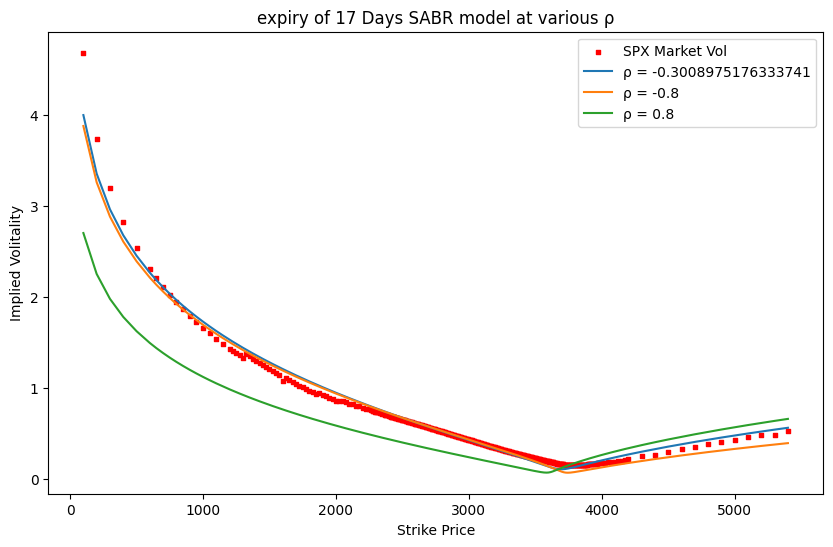

In [163]:
SABR_plot_effect(spx_smile[0], alpha, beta, rho_list, [nu_list[0]], "SPX")

# Conclusion: ρ range from (-1, 1), measures stock return and volatility. Negative correlation increases the price of out-of-the-money put options and decreases the price of out-of-the-money call options. Thus increasing ρ, the implied volitality seems rotating anti-clockwise.

> ## `SABR model` discussion
##  ν example: SPX data on T = 17

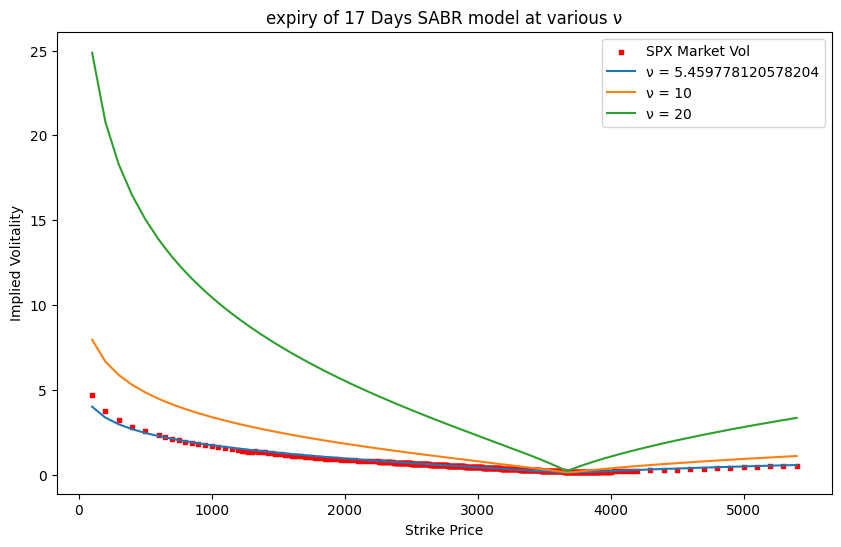

In [164]:
SABR_plot_effect(spx_smile[0], alpha, beta, [rho_list[0]], nu_list, "SPX")

# Conclusion: ν range from (0, ∞), controls the curvature. Bigger ν means more bending on the implied volitality graph